In [2]:
import numpy as np
import mdtraj as md

# 定义函数

使用FFT计算原子的MSD，[原帖](https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft)。以这几个函数作为参考尝试计算不同原子之间“MSD”的函数。

In [ ]:
def msd_straight_forward(r):
    shifts = np.arange(len(r))
    msds = np.zeros(shifts.size)    

    for i, shift in enumerate(shifts):
        diffs = r[:-shift if shift else None] - r[shift:]
        sqdist = np.square(diffs).sum(axis=1)
        msds[i] = sqdist.mean()

    return msds

def autocorrFFT(x):
  N=len(x)
  F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
  PSD = F * F.conjugate()
  res = np.fft.ifft(PSD)
  res= (res[:N]).real   #now we have the autocorrelation in convention B
  n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
  return res/n #this is the autocorrelation in convention A

def msd_fft(r):
  N=len(r)
  D=np.square(r).sum(axis=1) 
  D=np.append(D,0) 
  S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
  Q=2*D.sum()
  S1=np.zeros(N)
  for m in range(N):
      Q=Q-D[m-1]-D[N-m]
      S1[m]=Q/(N-m)
  return S1-2*S2

直接计算和使用FFT计算不同原子之间“MSD”的函数。直接计算效率很低，但可以用来对照FFT函数的结果。

不同文献里公式略有出入，主要是求极限的位置不同，暂且使用以下公式计算电导率

$\sigma=\lim\limits_{t\to\infty}\dfrac{e^2}{6tVk_B T}\sum_{i,j}z_i z_j\langle[(\vec{r}_i(t)-(\vec{r}_i(0)][(\vec{r}_j(t)-(\vec{r}_i(0)]\rangle$

最核心也是最复杂的部分是后面的系综平均，如果没有学习错的话，可以通过以下方式展开:

$\langle[(\vec{r}_i(t)-(\vec{r}_i(0)][(\vec{r}_j(t)-(\vec{r}_i(0)]\rangle$

$=\dfrac{1}{N-m}\sum_{k=0}^{N-m-1}[(\vec{r}_i(k+m)-(\vec{r}_i(k)][(\vec{r}_j(k+m)-(\vec{r}_i(k)]$

$=\dfrac{1}{N-m}\sum_{k=0}^{N-m-1}[\vec{r}_i(k+m)\vec{r}_j(k+m)+\vec{r}_i(k)\vec{r}_j(k)-\vec{r}_i(k+m)\vec{r}_j(k)-\vec{r}_i(k)\vec{r}_j(k+m)]$

仿照上面提到帖子的内容，在这里定义：

$S_1(m) = \dfrac{1}{N-m}\sum_{k=0}^{N-m-1}[\vec{r}_i(k+m)\vec{r}_j(k+m)+\vec{r}_i(k)\vec{r}_j(k)$

$S_2(m) = \dfrac{1}{N-m}\sum_{k=0}^{N-m-1}[\vec{r}_i(k+m)\vec{r}_j(k)+\vec{r}_i(k)\vec{r}_j(k+m)]$

对于$S_1(m)$,可以用以下递归求解，$S_2(m)$实际上是卷积，可以用FFT求解，但需要注意每次取哪些项。如果不清楚每项如何计算，建议先固定m，改变k，用简单的例子试一下，相信能够较快地理解如何求解。

$D(k)=\vec{r}_i(k)\vec{r}_j(k),\mathrm{for}k=0,1;\ldots,N-1,D(N)=0$

$Q=2\sum_{k=0}^{N-1}D(k)$

for $m=0,\ldots,N-1$

$Q=Q-D(m-1)-D(N-m)$

$S_1(m) = Q/(N-m)$

In [5]:
def cross_msd_straight_forward(positions_i, positions_j):
    """
    计算两个位置序列之间的均方位移（Cross-MSD）。
    
    参数：
    positions_i (numpy.ndarray)：表示位置序列 i 的数组，尺寸为 (N, d)，其中 N 为粒子/分子的数量，d 为维度（例如，二维或三维空间）。
    positions_j (numpy.ndarray)：表示位置序列 j 的数组，尺寸为 (N, d)，其中 N 为粒子/分子的数量，d 为维度（例如，二维或三维空间）。
    
    返回：
    C_m (numpy.ndarray)：表示 Cross-MSD 的结果向量，尺寸为 (N,)。
    """
    # 获取位置序列的长度（粒子/分子的数量）
    N = positions_i.shape[0]

    # 初始化一个长度为 N 的零向量，用于存储 Cross-MSD 的结果
    C_m = np.zeros(N)

    # 遍历所有的采样窗口 m
    for m in range(N):
        # 初始化点积和
        dot_products_sum = 0

        # 遍历每个位置序列，计算窗口大小为 m 的点积和
        for k in range(0, N-m):
            # 计算位置序列 i 的位移向量
            drift_i = positions_i[k+m] - positions_i[k]
            # 计算位置序列 j 的位移向量
            drift_j = positions_j[k+m] - positions_j[k]
            # 计算两个位移向量的点积，并累加到点积和
            dot_products_sum += np.dot(drift_i, drift_j)

        # 计算并存储当前窗口大小 m 的 Cross-MSD
        C_m[m] = dot_products_sum / (N-m)

    # 返回 Cross-MSD 结果向量
    return C_m

def cross_msd_fft(positions_i, positions_j):
    """
    使用快速傅里叶变换（FFT）方法计算两个位置序列之间的均方位移（Cross-MSD）。
    
    参数：
    positions_i (numpy.ndarray)：表示位置序列 i 的数组，尺寸为 (N, d)，其中 N 为粒子/分子的数量，d 为维度（例如，二维或三维空间）。
    positions_j (numpy.ndarray)：表示位置序列 j 的数组，尺寸为 (N, d)，其中 N 为粒子/分子的数量，d 为维度（例如，二维或三维空间）。
    
    返回：
    C_m (numpy.ndarray)：表示 Cross-MSD 的结果向量，尺寸为 (N,)。
    """
    # 获取位置序列的长度（粒子/分子的数量）和维度
    N, dimesion = positions_i.shape

    # 计算位置序列 i 和位置序列 j 之间的点积之和
    D = np.sum(np.multiply(positions_i, positions_j), axis=1)
    D = np.append(D, 0)
    Q = 2 * D.sum()
    S1 = np.zeros(N)
    
    # 计算 S1 部分，详见第二节的公式，这里采样窗口 m 从0开始取到n
    for m in range(N):
        Q = Q - D[m - 1] - D[N - m]
        S1[m] = Q / (N - m)

        
    # 计算 S2 部分，详见第二节的公式。注意，由于每个维度独立，先对不同维度分别求相关函数，再求和。凡治众如治寡，分数是也。
    correlate_array = sum([
        np.correlate(positions_i[:, i], positions_j[:, i], 'full')
        for i in range(dimesion)
    ])
    # 将S2的两部分求和，之后归一化
    S2 = correlate_array[:N] + correlate_array[::-1][:N]
    m_array = np.arange(1, N + 1)
    S2 /= m_array

    # 返回 Cross-MSD 结果向量，注意S2是反的，即 m 是从大到小的，S1中 m 从小到大
    return S1 - S2[::-1]


In [6]:
def center_trj_with_charge(resid_name="PF6", charge=-1):
    """
    计算指定残基名的每一个残基质心轨迹，并根据电荷创建电荷数组。

    参数：
    resid_name (str)：残基名称，默认为 "PF6"。
    charge (int)：残基的电荷，默认为 -1。

    返回：
    center_trj (list)：残基质心轨迹列表。
    charge_array (list)：电荷数组。
    """

    def center_trj(resid_name="PF6"):
        """
        计算指定残基名的每一个残基质心轨迹
        参数：
        resid_name (str)：残基名称，默认为 "PF6"。

        返回：
        center_trj (list)：残基质心轨迹列表。
        """
        
        resid_names = [str(res.index) for res in traj.topology.residues if res.name == resid_name]
        resid_atom_index = [traj.top.select("resid " + res) for res in resid_names]
        center_trj = [md.compute_center_of_mass(traj.atom_slice(atom_index)) for atom_index in resid_atom_index]
        return center_trj

    #根据电荷生成电荷列表
    center_trj = center_trj(resid_name)
    charge_array = [charge] * len(center_trj)

    return center_trj, charge_array

def all_msd(all_trj, all_charge):
    """
    计算所有轨迹之间的均方位移（MSD）。

    参数：
    all_trj (list)：轨迹列表。
    all_charge (list)：电荷列表。

    返回：
    total_msd (numpy.ndarray)：所有轨迹之间的总 MSD，尺寸为 (trj_length,)。
    """
    
    #初始化MSD数组
    total_msd = np.zeros(len(all_trj[0]))
    #生成电荷矩阵
    charge_matrix = np.tensordot(all_charge, all_charge, axes=0)

    #遍历所有轨迹（离子）对，计算MSD
    for i in range(len(all_trj)):
        for j in range(len(all_trj)):
            total_msd += cross_msd_fft(all_trj[i], all_trj[j]) * charge_matrix[i, j]

    return total_msd


# 计算MSD

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("data.csv")

In [ ]:
plt.plot(data['#"Time (ps)"'], data['Temperature (K)'])
plt.xlabel('time / ps')
plt.ylabel('Temperature / K')
plt.xlim(0, 10000)
plt.ylim(300, 350)

设定温度333K，有波动，但稳定在附近，这里取2000ps之后的轨迹计算电导率

In [3]:
traj = md.load("nvt10ns_unwrap_part.dcd", top="LiPF6_EC_DMC.pdb")
#选择2000ps之后的原子坐标，每1 ps 1帧，共8000帧.注意先用工具（如vmd）将轨迹unwrap
# traj = traj[2000:]

In [19]:
#计算所有MSD
trj1,charge1 = center_trj_with_charge("LI",1)
trj2,charge2 = center_trj_with_charge("PF6",-1)
all_trj = trj1+trj2
all_charge = charge1 + charge2

MSD = all_msd(all_trj,all_charge)

In [16]:
#计算对角项MSD
charge_matrix = np.tensordot(all_charge, all_charge, axes=0)
charge_matrix
MSD_diag = np.zeros(len(all_trj[0]))
for i in all_trj:
    MSD_diag += cross_msd_fft(i,i)

In [20]:
# np.save('MSD',MSD)
# np.save('MSD_diag',MSD_diag)

# 绘图和计算电导率

In [27]:
import os
import matplotlib.pyplot as plt

def plot_ax():
    fig, ax = plt.subplots(constrained_layout=True, figsize=(12 / 2.54, 9 / 2.54))
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 1600)
    ax.tick_params(width=1)
    ax.set_xlabel('$\mathrm{time\ (ns)}$')
    ax.set_ylabel('$\mathrm{MSD\ (nm)}^2$')
#     ax.set_xticks(np.arange(0,101,20))
#     ax.set_xticklabels(ax.get_xticks())
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    return ax

def plot_MSD(box):
    ax =  plot_ax()
    data = np.load(box)
    ax.plot(np.arange(len(data))*0.001,data,lw =1)    
    x = np.arange(len(data))*0.001 
    return ax

Text(0.5, 1.0, 'MSD')

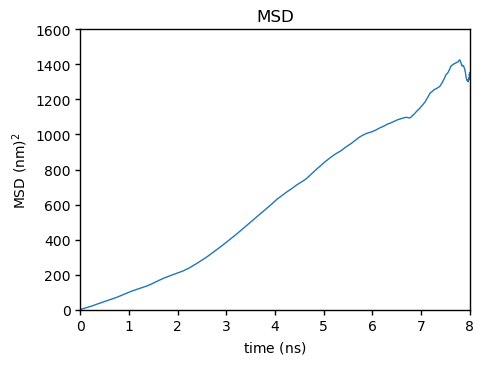

In [28]:
ax = plot_MSD('MSD.npy')
ax.set_xlim(0, 8)
ax.set_title('MSD')

Text(0.5, 1.0, 'MSD_diag')

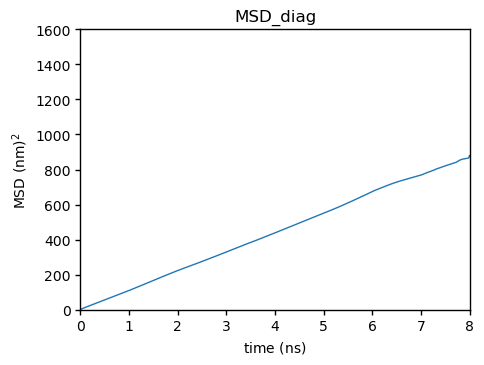

In [29]:
ax = plot_MSD('MSD_diag.npy')
ax.set_xlim(0, 8)
ax.set_title('MSD_diag')

In [33]:
from scipy.stats import linregress

def electrical_conductivity(MSD,timestep = 0.001):
    linear_model = linregress(np.arange(len(MSD))*timestep,MSD)
    slope = linear_model.slope
    error = linear_model.rvalue
    
    return slope

In [38]:
electrical_conductivity(MSD)

185.83583793355064

$\sigma=\lim\limits_{t\to\infty}\dfrac{e^2}{6tVk_B T}\sum_{i,j}z_i z_j\langle[(\vec{r}_i(t)-(\vec{r}_i(0)][(\vec{r}_j(t)-(\vec{r}_i(0)]\rangle=\dfrac{e^2}{6k_B T}\times V\cdot\dfrac{\langle[(\vec{r}_i(t)-(\vec{r}_i(0)][(\vec{r}_j(t)-(\vec{r}_i(0)]\rangle}{t}$

---
$e=1.602176634\times10^{-19}\text{C}$

$k_B=1.38064852(79)\times10^{-23}\text{J/K}$

$T = 333\text{K}$

$\text{S/m}=\text{kg}^{-1}\cdot\text{m}^{-3}\cdot \text{s}^3\cdot \text{A}^2$

$\text{C}^2/\text{(J/K}\cdot\text{K)} = \text{A}^2\cdot\text{s}^2/(\text{kg}\cdot\text{m}^2\cdot\text{s}^{-2})=\text{kg}^{-1}\cdot\text{m}^{-3}\cdot \text{s}^3\cdot \text{A}^2\times\text{m}\cdot\text{s}=\text{S/m}\times\text{m}\cdot\text{s}$

$\dfrac{e^2}{6k_B T} = 9.30555281102182\times10^{-19}\text{S/m}\times\text{m}\cdot\text{s} $  

---
$\dfrac{1}{V}\cdot\dfrac{\langle[(\vec{r}_i(t)-(\vec{r}_i(0)][(\vec{r}_j(t)-(\vec{r}_i(0)]\rangle}{t}$

$V$ 为$73.239265\ \text{nm}^3$，平均斜率为$185.83\ \text{nm}^2/\text{ns}$

则上式的值为 $2.537300176346663e\times10^{18}/(\text{m}\cdot\text{s})$

最终电导率的值为 $2.361\ \text{S/m} = 23.61\ \text{mS/cm}$，这个值与[文献](https://pubs.acs.org/doi/10.1021/jp809614h)中所报道的在同一数量级。注意到，MSD曲线较明显偏离直线，因此有这种误差并不奇怪。

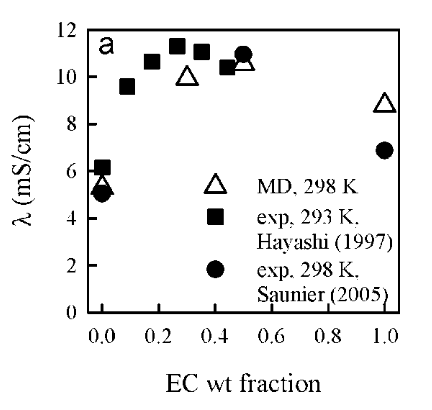

In [35]:
print((1.602176634*10**(-19))**2/(6*1.3806485*10**(-23)*333),traj.unitcell_volumes[-1],185.83/73.239265*10**18)

9.30555281102182e-19 73.239265 2.537300176346663e+18


In [36]:
9.30555281102182*2.537300176346663/10

2.361098078840885

In [32]:
# 写出部分轨迹，便于上传
# traj = md.load("output.dcd", top="LiPF6_EC_DMC.pdb")
# md.Trajectory(traj[:1000].xyz, traj.top).save_dcd('npt10ns_part.dcd')
# traj = md.load("nvt10ns_unwrap.dcd", top="LiPF6_EC_DMC.pdb")
# md.Trajectory(traj[:1000].xyz, traj.top).save_dcd('nvt10ns_unwrap_part.dcd')